# Dogs breeds

https://youtu.be/JNxcznsrRb8?t=1h31m8s

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

C:\tools\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
torch.cuda.set_device(0)

Kaggle Dog Breed Identification. Get data from https://www.kaggle.com/c/dog-breed-identification

In [4]:
PATH = "data/dogcatbreed/"
sz = 224
arch = resnext101_64
bs = 58

In [5]:
label_csv = f'{PATH}train.csv'
n = len(list(open(label_csv))) - 1 # header is not counted (-1)
val_idxs = get_cv_idxs(n) # random 20% data for validation set

In [6]:
n

7349

In [7]:
len(val_idxs)

1469

In [8]:
# If you haven't downloaded weights.tgz yet, download the file.
#     http://forums.fast.ai/t/error-when-trying-to-use-resnext50/7555
#     http://forums.fast.ai/t/lesson-2-in-class-discussion/7452/222
#!wget -O fastai/weights.tgz http://files.fast.ai/models/weights.tgz

In [9]:
#!tar xvfz fastai/weights.tgz -C fastai

## Initial exploration

In [10]:
!Powershell -Command "Get-ChildItem {PATH}"



    Directory: C:\Users\nissan.dookeran\Documents\Github\fastai\courses\dl1\data\dogcatbreed


Mode                LastWriteTime         Length Name                                                                  
----                -------------         ------ ----                                                                  
d-----        3/08/2018   3:55 PM                test                                                                  
d-----        3/08/2018   6:00 PM                tmp                                                                   
d-----        3/08/2018   3:54 PM                train                                                                 
-a----        3/08/2018   4:38 PM        1746967 sample_submission.csv                                                 
-a----       31/07/2018   6:26 PM         335581 train.csv                                                             




In [11]:
label_df = pd.read_csv(label_csv)

In [12]:
label_df.head()

,id,breed
0,b0234bf14351b079397d8685b2907e8d,keeshond
1,378e20d6c6c2f08fb0d9dce02b22caf4,newfoundland
2,b900795a1441629688fcd8935def1e4e,great_pyrenees
3,a8d369de5c7ef297d19316a19ab24501,great_pyrenees
4,8bff692933224c78840b10d3c1c22a16,leonberger


In [13]:
label_df.pivot_table(index="breed", aggfunc=len).sort_values('id', ascending=False)

,id
breed,
yorkshire_terrier,200
samoyed,200
russian_blue,200
ragdoll,200
pug,200
pomeranian,200
persian,200
miniature_pinscher,200
maine_coon,200


In [14]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}train.csv', test_name='test', # we need to specify where the test set is if you want to submit to Kaggle competitions
                                   val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)

In [15]:
fn = PATH + data.trn_ds.fnames[0]; fn

'data/dogcatbreed/train\\000a8443ac7c40053b19e526e08af73e.jpg'

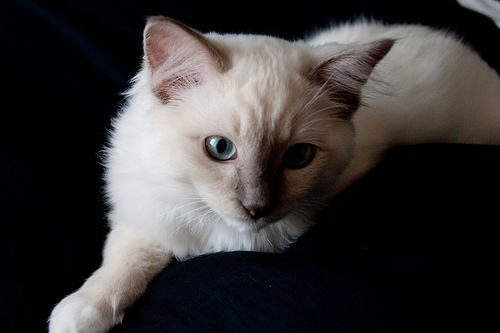

In [16]:
img = PIL.Image.open(fn); img

In [17]:
img.size

(500, 333)

In [18]:
size_d = {k: PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames}

In [19]:
row_sz, col_sz = list(zip(*size_d.values()))

In [20]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [21]:
row_sz[:5]

array([500, 500, 300, 300, 330])

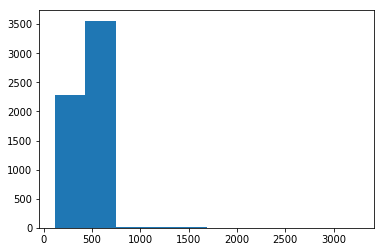

In [22]:
plt.hist(row_sz);

(array([  78.,  242., 1744.,  317., 3404.,   45.,   16.,    5.,    2.,    2.]),
 array([114. , 201.6, 289.2, 376.8, 464.4, 552. , 639.6, 727.2, 814.8, 902.4, 990. ]),
 <a list of 10 Patch objects>)

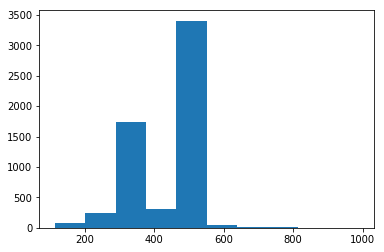

In [23]:
plt.hist(row_sz[row_sz < 1000])

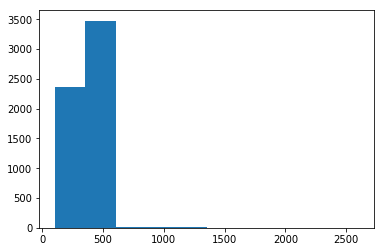

In [24]:
plt.hist(col_sz);

(array([  45.,  460., 1927., 1589., 1795.,   24.,    2.,    6.,   11.,    5.]),
 array([103. , 188.9, 274.8, 360.7, 446.6, 532.5, 618.4, 704.3, 790.2, 876.1, 962. ]),
 <a list of 10 Patch objects>)

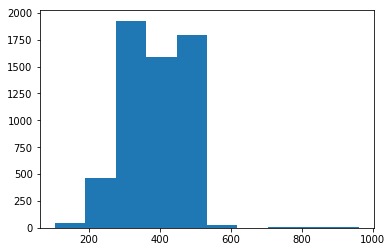

In [25]:
plt.hist(col_sz[col_sz < 1000])

In [26]:
len(data.trn_ds), len(data.test_ds)

(5880, 6849)

In [27]:
len(data.classes), data.classes[:5]

(37,
 ['abyssinian',
  'american_bulldog',
  'american_pit_bull_terrier',
  'basset_hound',
  'beagle'])

## Initial model

In [28]:
def get_data(sz, bs): # sz: image size, bs: batch size
    tmfs = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}train.csv', test_name='test',
                                       val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/13
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/37
    return data if sz > 300 else data.resize(340, 'tmp') # Reading the jpgs and resizing is slow for big images, so resizing them all to 340 first saves time

#Source:   
#    def resize(self, targ, new_path):
#        new_ds = []
#        dls = [self.trn_dl,self.val_dl,self.fix_dl,self.aug_dl]
#        if self.test_dl: dls += [self.test_dl, self.test_aug_dl]
#        else: dls += [None,None]
#        t = tqdm_notebook(dls)
#        for dl in t: new_ds.append(self.resized(dl, targ, new_path))
#        t.close()
#        return self.__class__(new_ds[0].path, new_ds, self.bs, self.num_workers, self.classes)
#File:      ~/fastai/courses/dl1/fastai/dataset.py

### Precompute

In [29]:
data = get_data(sz, bs)

In [30]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|████████████████████████████████████████████████████████████████████████████████| 119/119 [03:52<00:00,  1.95s/it]


In [31]:
learn.fit(1e-2, 5)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.518949   0.240855   0.929884  
    1      0.261587   0.204508   0.927161                                                                              
    2      0.178574   0.203608   0.926481                                                                              
    3      0.142948   0.199266   0.929884                                                                              
    4      0.11595    0.204777   0.930565                                                                              



[array([0.20478]), 0.9305650153234754]

### Augment

In [32]:
from sklearn import metrics

In [33]:
data = get_data(sz, bs)

In [34]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [35]:
learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.646854   0.268172   0.923758  
    1      0.329252   0.236605   0.927842                                                                              



[array([0.2366]), 0.9278420678525656]

In [36]:
learn.precompute = False

In [37]:
learn.fit(1e-2, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.281717   0.216017   0.932607  
    1      0.258899   0.205963   0.93533                                                                               
    2      0.24032    0.1992     0.932607                                                                              
    3      0.223276   0.202065   0.93533                                                                               
    4      0.196845   0.197096   0.933288                                                                              



[array([0.1971]), 0.9332879575602127]

In [38]:
learn.save('224_pre')

In [39]:
learn.load('224_pre')

## Increase size

In [40]:
# Starting training on small images for a few epochs, then switching to bigger images, and continuing training is an amazingly effective way to avoid overfitting.

# http://forums.fast.ai/t/planet-classification-challenge/7824/96
# set_data doesn’t change the model at all. It just gives it new data to train with.
learn.set_data(get_data(299, bs)) 
learn.freeze()

#Source:   
#    def set_data(self, data, precompute=False):
#        super().set_data(data)
#        if precompute:
#            self.unfreeze()
#            self.save_fc1()
#            self.freeze()
#            self.precompute = True
#        else:
#            self.freeze()
#File:      ~/fastai/courses/dl1/fastai/conv_learner.py

In [41]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

In [42]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.187994   0.197671   0.93533   
    1      0.183297   0.191265   0.938053                                                                              
    2      0.179325   0.192477   0.938053                                                                              



[array([0.19248]), 0.9380531029444799]

Validation loss is much lower than training loss. This is a sign of underfitting. Cycle_len=1 may be too short. Let's set cycle_mult=2 to find better parameter.

In [43]:
# When you are under fitting, it means cycle_len=1 is too short (learning rate is getting reset before it had the chance to zoom in properly).
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2) # 1+2+4 = 7 epochs

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.167227   0.193778   0.934649  
    1      0.165063   0.1878     0.936692                                                                              
    2      0.153432   0.187338   0.93533                                                                               
    3      0.162182   0.186619   0.939415                                                                              
    4      0.149597   0.187994   0.934649                                                                              
    5      0.136034   0.183853   0.939415                                                                              
    6      0.12923    0.184903   0.939415                                                                              



[array([0.1849]), 0.939414569356151]

Training loss and validation loss are getting closer and smaller. We are on right track.

In [44]:
log_preds, y = learn.TTA() # (5, 2044, 120), (2044,)
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9360108917631041, 0.17570000522604548)

In [45]:
len(data.val_ds.y), data.val_ds.y[:5]

(1469, array([13,  8, 31, 24, 36], dtype=int64))

In [46]:
learn.save('299_pre')

In [47]:
learn.load('299_pre')

In [48]:
learn.fit(1e-2, 1, cycle_len=2) # 1+1 = 2 epochs

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.142866   0.186005   0.943499  
    1      0.137315   0.18595    0.943499                                                                              



[array([0.18595]), 0.9434989803579082]

In [49]:
learn.save('299_pre')

In [50]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9400953029271614, 0.18039428913418132)

This dataset is so similar to ImageNet dataset. Training convolution layers doesn't help much. We are not going to unfreeze.

## Create submission

https://youtu.be/9C06ZPF8Uuc?t=1905

In [51]:
data.classes

['abyssinian',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'bengal',
 'birman',
 'bombay',
 'boxer',
 'british_shorthair',
 'chihuahua',
 'egyptian_mau',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'maine_coon',
 'miniature_pinscher',
 'newfoundland',
 'persian',
 'pomeranian',
 'pug',
 'ragdoll',
 'russian_blue',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'siamese',
 'sphynx',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [52]:
data.test_ds.fnames

['test\\0006246bf61f5801e125c305d2ed25e2.jpg',
 'test\\001e73b6915f4128065470cdd3766fcd.jpg',
 'test\\002d5910de023eddce8358edf169c07f.jpg',
 'test\\003b7dec4fe65ec846854c7597617a23.jpg',
 'test\\004955e30603d8c06c1ff917736eb418.jpg',
 'test\\006698c81695d7249438abe28fcc14aa.jpg',
 'test\\0067ecf8de1202baef9064a1bcbce6c3.jpg',
 'test\\0091c20924fb3fe05c1639b19b98fe3f.jpg',
 'test\\00a5981bbe7cdc374385c46792219b90.jpg',
 'test\\00aa13b24da06a2f4ffef1742d2c400d.jpg',
 'test\\00afaa4f2a5e18df354294671081b8c8.jpg',
 'test\\00b79452a6a98c02d9489189b16f5cc8.jpg',
 'test\\00bb022c5622be19209010e94b82cdae.jpg',
 'test\\00bbb23263b12d84fd41f04b83367a7d.jpg',
 'test\\00d1c95ec4752fbeeb372484ca65ffde.jpg',
 'test\\00e5bb8a838164b484caafeb0bc6ffb2.jpg',
 'test\\00f0b3a43e973b3611f06836a2bc6180.jpg',
 'test\\00f3feb014bd7f15ead675f43c7c4664.jpg',
 'test\\011e1e752a5b51e53082cd7f7633db13.jpg',
 'test\\0129e7168fc7a522ffae0fe60b8f0dbf.jpg',
 'test\\013167adb9fbc93923f9c0789599ec95.jpg',
 'test\\01391

In [53]:
log_preds, y = learn.TTA(is_test=True) # use test dataset rather than validation dataset
probs = np.mean(np.exp(log_preds),0)
#accuracy_np(probs, y), metrcs.log_loss(y, probs) # This does not make sense since test dataset has no labels

In [54]:
probs.shape # (n_images, n_classes)

(6849, 37)

In [55]:
df = pd.DataFrame(probs)
df.columns = data.classes

In [56]:
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])

In [57]:
df.head()

,id,abyssinian,american_bulldog,american_pit_bull_terrier,basset_hound,beagle,bengal,birman,bombay,boxer,...,russian_blue,saint_bernard,samoyed,scottish_terrier,shiba_inu,siamese,sphynx,staffordshire_bull_terrier,wheaten_terrier,yorkshire_terrier
0,0006246bf61f5801e125c305d2ed25e2,0.000024,9.302803e-04,8.348347e-05,2.856444e-04,8.845101e-05,2.067092e-05,1.197473e-03,5.177408e-05,4.897722e-03,...,0.000242,2.461354e-04,1.469806e-05,6.722203e-05,3.523675e-04,7.852873e-04,0.000088,0.002705,5.499044e-05,8.318319e-06
1,001e73b6915f4128065470cdd3766fcd,0.000205,5.162286e-07,1.159071e-07,3.184562e-06,7.174638e-07,4.910580e-03,2.630509e-07,8.767185e-05,9.039115e-07,...,0.000166,2.192435e-06,1.028675e-06,2.328075e-06,4.397160e-06,5.154699e-07,0.000198,0.000005,9.456857e-07,4.113114e-06
2,002d5910de023eddce8358edf169c07f,0.000002,1.697872e-05,3.168460e-06,6.642448e-06,3.025256e-06,9.637281e-06,3.090910e-05,1.093199e-04,3.851971e-05,...,0.000043,1.369950e-05,9.979615e-01,2.047187e-05,3.971317e-04,5.358793e-06,0.000005,0.000143,1.911461e-05,6.413732e-06
3,003b7dec4fe65ec846854c7597617a23,0.000006,3.861413e-05,9.972152e-04,2.883191e-07,2.485241e-05,3.309908e-08,2.213677e-07,4.042757e-07,1.871564e-05,...,0.000009,5.410936e-07,1.076201e-07,2.079883e-07,4.970302e-08,3.407308e-07,0.000003,0.000010,1.628524e-06,1.220689e-07
4,004955e30603d8c06c1ff917736eb418,0.000058,6.187527e-07,4.114690e-07,1.246072e-06,3.076516e-06,7.370977e-06,2.668647e-06,9.977140e-01,1.921804e-07,...,0.002005,5.220387e-07,1.518443e-06,2.560025e-06,7.532249e-07,3.807629e-05,0.000001,0.000001,9.268205e-07,2.496339e-06


In [58]:
SUBM = f'{PATH}/subm/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)

In [59]:
FileLink(f'{SUBM}subm.gz')

C:\Users\nissan.dookeran\Documents\Github\fastai\courses\dl1\data\dogcatbreed\subm\subm.gz

## Individual prediction

In [60]:
fn = data.val_ds.fnames[0]
fn

'train\\00076dfc1e76744c60b7db2f20edb5db.jpg'

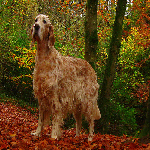

In [61]:
Image.open(PATH + fn).resize((150, 150))

In [62]:
# Method 1.
trn_tfms, val_tfms = tfms_from_model(arch, sz)
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
np.argmax(preds)

13

In [63]:
learn.data.classes[np.argmax(preds)]

'english_setter'

In [64]:
# Method 2.
trn_tfms, val_tfms = tfms_from_model(arch, sz)
im = val_tfms(open_image(PATH + fn)) # open_image() returns numpy.ndarray
preds = learn.predict_array(im[None])
np.argmax(preds)

13